# Workspace Setup

## Some Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.notebook import tqdm
import numpy as np
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from transformers import RobertaTokenizer, RobertaForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model
import time
from wordcloud import WordCloud

# Download the NLTK punkt tokenizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/salvatore/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/salvatore/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/salvatore/.local/lib/python3.10

AttributeError: _ARRAY_API not found

[nltk_data] Downloading package punkt to /home/salvatore/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/salvatore/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/salvatore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Some Constants

In [2]:
MAX_LEN = 256
RANDOM_SEED = 42
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RESULTS_DIR = './results'

## Useful functions

In [3]:
def stars_to_sentiment(stars):
    """
    Convert star ratings to sentiment labels.
    1-2 stars: Negative, 3 stars: Neutral, 4-5 stars: Positive
    """
    if stars <= 1:
        return "Negative"
    elif stars == 2:
        return "Neutral"
    else:
        return "Positive"

################### transformers ######################
# Tokenizer 
def tokenize_reviews(df, tokenizer, max_length=512):
    encodings = tokenizer(
        df["Review"].tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    labels = torch.tensor(df["Rating"].values)
    return encodings, labels

# Unpack the encodings (input_ids and attention_mask)
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
    
    def __len__(self):
        return len(self.labels)
    
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    prec, rec, f_score, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"precision": prec,
            "recall": rec,
            "f1": f_score}
    
################### LSTM ######################

# Encode sentences with padding and OOV handling
def encode_sentence(tokens, vocab, max_len):
    encoded = [vocab.get(word, vocab["<OOV>"]) for word in tokens]
    padded = encoded[:max_len] + [vocab["<PAD>"]] * max(0, max_len - len(encoded))
    return padded

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Check whether the GPU is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print("Using device:", device)

True
1
NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda


## Dataset

### Download

In [5]:
# Download latest version
dataset_path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

print("Path to dataset files:", dataset_path)

Path to dataset files: /home/salvatore/.cache/kagglehub/datasets/andrewmvd/trip-advisor-hotel-reviews/versions/2


### Dataloading on Pandas + preprocessing

In [6]:
# Load the dataset CSV file
df = pd.read_csv(f"{dataset_path}/tripadvisor_hotel_reviews.csv")
df["Rating"] = df["Rating"] - 1 # Convert 1–5 to 0–4

stop_words = set(stopwords.words('english'))

# removing html tags and converting to lowercase
df["Review"] = df["Review"].str.lower()
df["Review"] = df["Review"].str.replace(r"<.*?>", "", regex=True)
df["Review"] = df["Review"].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Initialize the tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Step 1: Add a column with the number of tokens per review
token_counts = tokenizer(
    df["Review"].tolist(),
    padding=False,
    truncation=False,
    return_length=True
)["length"]
df["token_count"] = token_counts

# Step 2: Drop reviews with token_count > MAX_LEN
df_filtered = df[df["token_count"] <= MAX_LEN].reset_index(drop=True)

# Step 3: (Optional) Check new distribution
print("New dataset size:", len(df_filtered))
print(df_filtered["token_count"].describe())

print(df_filtered["Rating"].value_counts())

# First, shuffle and split off the test set
df_temp, df_test = train_test_split(df_filtered, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True)

# Then, split the remaining into train and validation
df_train, df_val = train_test_split(df_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED, shuffle=True)

# Optionally, reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

print(df_filtered.head())


Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors


New dataset size: 18273
count    18273.000000
mean       104.469053
std         54.736717
min         11.000000
25%         62.000000
50%         93.000000
75%        138.000000
max        256.000000
Name: token_count, dtype: float64
Rating
4    8270
3    5338
2    1911
1    1518
0    1236
Name: count, dtype: int64
Train size: 13202
Validation size: 2330
Test size: 2741
                                              Review  Rating  token_count
0  nice hotel expensive parking got good deal sta...       3          103
1  unique, great stay, wonderful time hotel monac...       4          117
2  great stay great stay, went seahawk game aweso...       4          242
3  love monaco staff husband stayed hotel crazy w...       4          186
4  cozy stay rainy city, husband spent 7 nights m...       4          132


### Visualization

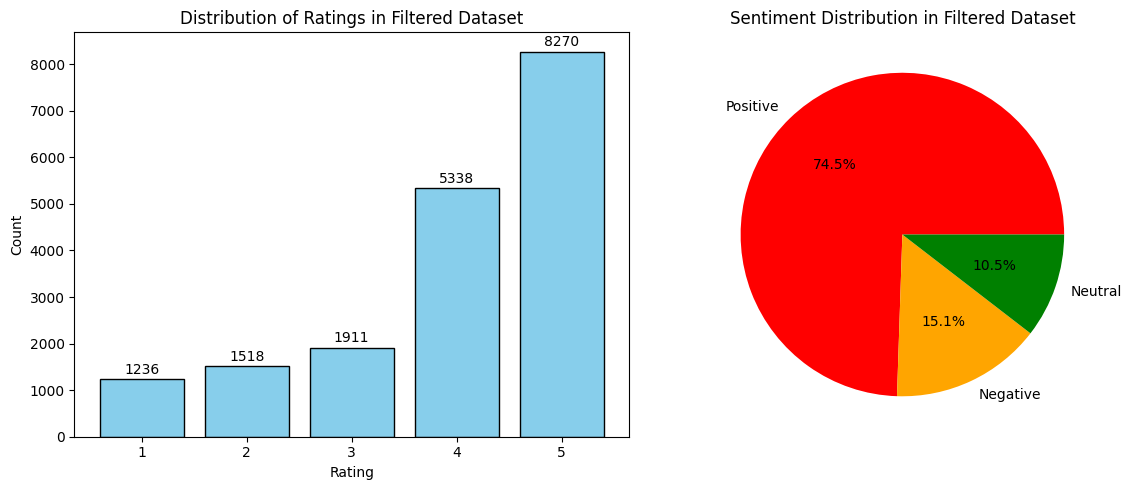

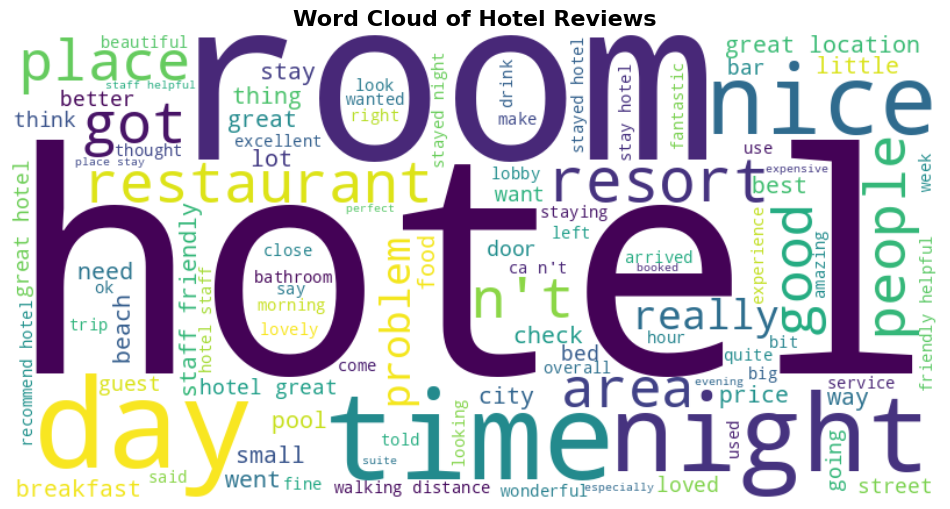

In [7]:
# Plot label distribution
plt.figure(figsize=(12, 5))

# Subplot 1: Rating distribution
plt.subplot(1, 2, 1)
rating_counts = df_filtered['Rating'].value_counts().sort_index()
# Offset labels by 1 for display (since ratings are 0–4, but original scale is 1–5)
labels_offset = [i + 1 for i in rating_counts.index]
plt.bar(labels_offset, rating_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Filtered Dataset')
plt.xticks(labels_offset)
for i, count in zip(labels_offset, rating_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='bottom')

# Subplot 2: Sentiment distribution (using stars_to_sentiment function)
plt.subplot(1, 2, 2)
df_filtered['Sentiment'] = df_filtered['Rating'].apply(stars_to_sentiment)
sentiment_counts = df_filtered['Sentiment'].value_counts()
colors = ['red', 'orange', 'green']
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors)
plt.title('Sentiment Distribution in Filtered Dataset')

plt.tight_layout()
plt.savefig('report/images/label_distribution.png')
plt.show()

# Word Cloud

# Combine all reviews into one text
all_text = ' '.join(df_filtered['Review'].values)

# Generate word cloud
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Hotel Reviews', fontsize=16, fontweight='bold')
plt.savefig('report/images/wordcloud.png')
plt.show()

### Torch Dataloaders

#### RoBERTa dataloaders

In [8]:
# Tokenize train, validation, and test sets
train_encodings = tokenize_reviews(df_train, tokenizer)
val_encodings = tokenize_reviews(df_val, tokenizer)
test_encodings = tokenize_reviews(df_test, tokenizer)

# Build datasets
train_dataset = EncodedDataset(*train_encodings)
val_dataset = EncodedDataset(*val_encodings)
test_dataset = EncodedDataset(*test_encodings)
# Only keep the first 100 entries for each dataset
mock_dataset = EncodedDataset(
    {k: v[:100] for k, v in train_encodings[0].items()},
    train_encodings[1][:100]
)

# Create DataLoaders
train_loader_bert = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_bert = DataLoader(val_dataset, batch_size=32)
test_loader_bert = DataLoader(test_dataset, batch_size=32)
mock_loader_bert = DataLoader(mock_dataset, batch_size=8)

#### LSTM dataloaders

In [9]:
texts = df_filtered["Review"].values
print("Number of reviews:", len(texts))
labels = df_filtered["Rating"].values

# Tokenize and build vocab
tokenized_texts = [word_tokenize(text.lower()) for text in texts]
vocab = Counter([word for sentence in tokenized_texts for word in sentence])
vocab = {word: i+2 for i, (word, _) in enumerate(vocab.most_common(10000))}
vocab["<PAD>"] = 0
vocab["<OOV>"] = 1

encoded_texts = [encode_sentence(tokens, vocab, MAX_LEN) for tokens in tokenized_texts]

# Split encoded_texts and labels into train, val, test sets (same sizes as before)
encoded_texts = np.array(encoded_texts)
labels = np.array(labels)

X_temp, X_test, y_temp, y_test = train_test_split(
    encoded_texts, labels, test_size=TEST_SIZE, random_state=RANDOM_SEED, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE, random_state=RANDOM_SEED, shuffle=True
)

print(f"LSTM splits - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# 2. Create Dataset
train_dataset_lstm = ReviewDataset(X_train, y_train)
val_dataset_lstm = ReviewDataset(X_val, y_val)
test_dataset_lstm = ReviewDataset(X_test, y_test)

# 3. Create DataLoaders
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=16, shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=32)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=32)

Number of reviews: 18273
LSTM splits - Train: 13202, Val: 2330, Test: 2741


# Transformer based Model

## Model definition

In [10]:
class SA_Model():
    def __init__(self, model_name="roberta-base", num_labels=5):
        self.model_name = model_name
        self.num_labels = num_labels
        self.model = RobertaForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels)
        
    def apply_lora(self, rank=16):
        lora_config = LoraConfig(
            r=rank,
            lora_alpha=32,
            lora_dropout=0.1,
            bias="none",
            task_type="SEQ_CLS",  # For sequence classification
            target_modules=["query", "value"],
        )
        self.model = get_peft_model(self.model, lora_config)
        
    def freeze_all_except_lora(self):
        """Freeze all base model weights except LoRA adapters"""
        for name, param in self.model.named_parameters():
            if "lora" not in name:
                param.requires_grad = False

    def unfreeze_classifier(self):
        """Unfreeze the classifier layer for fine-tuning"""
        for name, param in self.model.named_parameters():
            if "classifier" in name:
                param.requires_grad = True

    def get_model(self):
        return self.model
    
    def get_trainable_parameters(self):
        # for name, param in self.model.named_parameters():
        #     if param.requires_grad:
        #         print("Trainable:", name)
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.model.parameters())
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,} ({100 * trainable_params / total_params:.2f}%)")

## Model evaluation function

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()
    return accuracy, precision, recall, f1, cm

def evaluate_model_as_sentiment(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            outputs = model(**inputs)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs[0]
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = [stars_to_sentiment(pred) for pred in all_preds]
    all_labels = [stars_to_sentiment(label) for label in all_labels]

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
    disp.plot(cmap='Blues')
    plt.show()
    return accuracy, precision, recall, f1, cm

## Training

In [12]:
model = SA_Model()
model.apply_lora(rank=32)
model.freeze_all_except_lora() 
model.unfreeze_classifier()
model.get_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 2,368,522 / 126,423,562 (1.87%)


In [ ]:
training_args = TrainingArguments(
    output_dir=RESULTS_DIR + "/transfomer",     # Where checkpoints/logs go
    per_device_train_batch_size=16,             # Batch size per GPU
    per_device_eval_batch_size=16,
    num_train_epochs=20,                        # Total number of training epochs
    learning_rate=3e-5,
    warmup_ratio=0.1,                           # 10% of training steps for warmup
    eval_strategy="epoch",                      # Run eval at end of every epoch
    save_strategy="epoch",                      # Save checkpoint every epoch
    logging_strategy="steps",
    logging_steps=100,
    fp16=True,                           
    save_total_limit=5,                         # Only keep the last 5 checkpoints
    load_best_model_at_end=True,                # Use best checkpoint (based on metric)
    metric_for_best_model="f1",                 # Choose best model by accuracy
    greater_is_better=True,
)

trainer = Trainer(
    model=model.get_model(),
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  
)

trainer.train()

trainer.save_model(f"lora_tripadvisor_{time.strftime('%Y%m%d_%H%M%S')}")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,1.037600,0.943154,0.565327,0.593991,0.556983
2,0.852600,0.799598,0.652391,0.657511,0.653792
3,0.804700,0.765051,0.650603,0.660944,0.650230
4,0.816700,0.748247,0.669002,0.674678,0.670030
5,0.733900,0.747430,0.673160,0.681116,0.675876
6,0.777600,0.744094,0.665060,0.676824,0.666514
7,0.741000,0.732825,0.671342,0.686266,0.672358


In [ ]:
model.model.save_pretrained(f"{RESULTS_DIR}/transfomer/")
tokenizer.save_pretrained(f"{RESULTS_DIR}/transfomer/")

('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.json',
 './results/merges.txt',
 './results/added_tokens.json')

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Accuracy: 0.6775
Precision: 0.6678, Recall: 0.6775, F1 Score: 0.6709
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       209
           1       0.53      0.50      0.51       226
           2       0.53      0.45      0.48       287
           3       0.60      0.54      0.57       812
           4       0.76      0.84      0.80      1207

    accuracy                           0.68      2741
   macro avg       0.63      0.62      0.62      2741
weighted avg       0.67      0.68      0.67      2741



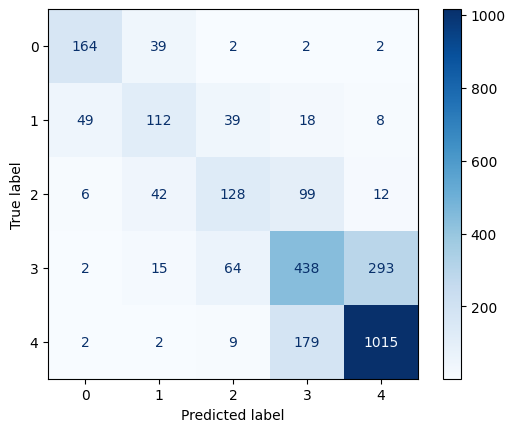

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Accuracy: 0.8818
Precision: 0.8751, Recall: 0.8818, F1 Score: 0.8780
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84       435
     Neutral       0.53      0.45      0.48       287
    Positive       0.93      0.95      0.94      2019

    accuracy                           0.88      2741
   macro avg       0.77      0.75      0.76      2741
weighted avg       0.88      0.88      0.88      2741



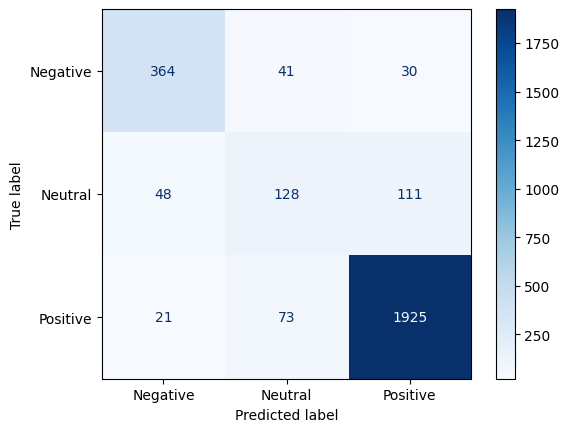

(0.8817949653411163,
 0.875115138206264,
 0.8817949653411163,
 0.8779930958304691,
 array([[ 364,   41,   30],
        [  48,  128,  111],
        [  21,   73, 1925]]))

In [15]:
evaluate_model(model.get_model(), test_loader_bert)
evaluate_model_as_sentiment(model.get_model(), test_loader_bert)

# LSTM based Model

## Model definition

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        out = self.dropout(hidden[-1])
        return self.fc(out)

## Training function

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    
    return accuracy, precision, recall, f1

def evaluate_model_as_sentiment(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = [stars_to_sentiment(pred) for pred in all_preds]
    all_labels = [stars_to_sentiment(label) for label in all_labels]
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    
    return accuracy, precision, recall, f1

def train_model(model, train_loader, val_loader, num_epochs=100, plot=False, patience=5, min_epochs=60):
    train_losses = []
    val_losses = []
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Training Loss: {total_loss / len(train_loader)}")
        train_losses.append(total_loss / len(train_loader))

        # Evaluate on validation set every epoch
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        labels_list = []
        outputs_list = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                labels_list.extend(labels.cpu().numpy())
                outputs_list.extend(predicted.cpu().numpy())
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        
        val_accuracy = val_correct / val_total
        val_loss_avg = val_loss / len(val_loader)
        val_losses.append(val_loss_avg)
        prec, rec, f_score, _ = precision_recall_fscore_support(labels_list, outputs_list, average='weighted')
        print(f"Validation Loss: {val_loss_avg:.4f},")
        print(f"Validation Accuracy: {val_accuracy:.4f},")
        print(f"Precision: {prec:.4f},")
        print(f"Recall: {rec:.4f},")
        print(f"F1 Score: {f_score:.4f}")
        model.train()

        # Early stopping implementation
        if epoch == 0:
            best_f_score = f_score
            epochs_without_improvement = 0
        else:
            if f_score > best_f_score:
                best_f_score = f_score
                epochs_without_improvement = 0
                # Save best model
                torch.save(model.state_dict(), RESULTS_DIR + '/lstm/best_model.pth')
            else:
                epochs_without_improvement += 1
                
            if epochs_without_improvement >= patience and epoch >= min_epochs:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break

    # Plot training loss
    if plot:
        plt.figure()
        plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.legend()
        plt.show()

## Training

Epoch 1/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3627023460934296
Validation Loss: 1.3197,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3482538341177
Validation Loss: 1.3245,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3478209308504192
Validation Loss: 1.3200,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 4/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3473285404879591
Validation Loss: 1.3218,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 5/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3472097870368358
Validation Loss: 1.3220,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 6/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3486559494211368
Validation Loss: 1.3207,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 7/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.346317372223944
Validation Loss: 1.3194,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3472225289367878
Validation Loss: 1.3195,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 9/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3465554862132083
Validation Loss: 1.3201,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 10/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3472891993297502
Validation Loss: 1.3316,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3473049443368472
Validation Loss: 1.3202,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 12/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3464915091419913
Validation Loss: 1.3192,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 13/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.347910535609751
Validation Loss: 1.3243,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 14/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3460070493723522
Validation Loss: 1.3234,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.346508203060806
Validation Loss: 1.3232,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.346599209900341
Validation Loss: 1.3196,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 17/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3461337790217873
Validation Loss: 1.3189,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3471940557402502
Validation Loss: 1.3193,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 19/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3457241704186862
Validation Loss: 1.3219,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.346626610357594
Validation Loss: 1.3206,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 21/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3460616712564417
Validation Loss: 1.3204,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 22/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3457901238962178
Validation Loss: 1.3206,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 23/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.346195072079975
Validation Loss: 1.3199,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 24/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3460070679897835
Validation Loss: 1.3727,
Validation Accuracy: 0.4579,
Precision: 0.2371,
Recall: 0.4579,
F1 Score: 0.3109


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 25/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3470902560553886
Validation Loss: 1.3203,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 26/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3446269881061435
Validation Loss: 1.3208,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 27/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.345618075738519
Validation Loss: 1.3201,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 28/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3435132697621501
Validation Loss: 1.3203,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 29/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3434857567343816
Validation Loss: 1.3204,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 30/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3446049544482197
Validation Loss: 1.3184,
Validation Accuracy: 0.4764,
Precision: 0.2270,
Recall: 0.4764,
F1 Score: 0.3074


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 31/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3445762302771607
Validation Loss: 1.3333,
Validation Accuracy: 0.4708,
Precision: 0.2391,
Recall: 0.4708,
F1 Score: 0.3109


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 32/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3457974106722825
Validation Loss: 1.3186,
Validation Accuracy: 0.4764,
Precision: 0.2271,
Recall: 0.4764,
F1 Score: 0.3076


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 33/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3441152361922921
Validation Loss: 1.3192,
Validation Accuracy: 0.4768,
Precision: 0.2759,
Recall: 0.4768,
F1 Score: 0.3087


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 34/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3420439746420263
Validation Loss: 1.3198,
Validation Accuracy: 0.4764,
Precision: 0.2273,
Recall: 0.4764,
F1 Score: 0.3078


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 35/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3415791043069114
Validation Loss: 1.3207,
Validation Accuracy: 0.4764,
Precision: 0.3226,
Recall: 0.4764,
F1 Score: 0.3101


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 36/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3416696347422519
Validation Loss: 1.3275,
Validation Accuracy: 0.4725,
Precision: 0.3125,
Recall: 0.4725,
F1 Score: 0.3110


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 37/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.341331039444875
Validation Loss: 1.3200,
Validation Accuracy: 0.4768,
Precision: 0.3953,
Recall: 0.4768,
F1 Score: 0.3118


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 38/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3384274997665
Validation Loss: 1.3204,
Validation Accuracy: 0.4764,
Precision: 0.2550,
Recall: 0.4764,
F1 Score: 0.3093


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 39/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.3363595115647766
Validation Loss: 1.3027,
Validation Accuracy: 0.4777,
Precision: 0.3183,
Recall: 0.4777,
F1 Score: 0.3161


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 40/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.2828833075470267
Validation Loss: 1.2280,
Validation Accuracy: 0.4833,
Precision: 0.3301,
Recall: 0.4833,
F1 Score: 0.3447


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 41/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.231232939996096
Validation Loss: 1.2068,
Validation Accuracy: 0.4901,
Precision: 0.3675,
Recall: 0.4901,
F1 Score: 0.3995


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 42/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.1892288980270413
Validation Loss: 1.1865,
Validation Accuracy: 0.4936,
Precision: 0.4413,
Recall: 0.4936,
F1 Score: 0.4323


Epoch 43/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.1541608134713068
Validation Loss: 1.1492,
Validation Accuracy: 0.5030,
Precision: 0.4396,
Recall: 0.5030,
F1 Score: 0.4426


Epoch 44/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.1292060975878349
Validation Loss: 1.1335,
Validation Accuracy: 0.5099,
Precision: 0.4396,
Recall: 0.5099,
F1 Score: 0.4485


Epoch 45/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.169250444768416
Validation Loss: 1.1975,
Validation Accuracy: 0.5202,
Precision: 0.4170,
Recall: 0.5202,
F1 Score: 0.4097


Epoch 46/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.21136480389438
Validation Loss: 1.1846,
Validation Accuracy: 0.5163,
Precision: 0.3776,
Recall: 0.5163,
F1 Score: 0.3822


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 47/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.1598254500665042
Validation Loss: 1.1294,
Validation Accuracy: 0.5056,
Precision: 0.3908,
Recall: 0.5056,
F1 Score: 0.4059


Epoch 48/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.090550185620929
Validation Loss: 1.1009,
Validation Accuracy: 0.5172,
Precision: 0.4595,
Recall: 0.5172,
F1 Score: 0.4656


Epoch 49/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.045813962708951
Validation Loss: 1.1066,
Validation Accuracy: 0.5052,
Precision: 0.4386,
Recall: 0.5052,
F1 Score: 0.4570


/home/salvatore/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 50/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 1.0142866648715576
Validation Loss: 1.0675,
Validation Accuracy: 0.5356,
Precision: 0.4907,
Recall: 0.5356,
F1 Score: 0.4945


Epoch 51/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.9994922865533944
Validation Loss: 1.0528,
Validation Accuracy: 0.5382,
Precision: 0.5000,
Recall: 0.5382,
F1 Score: 0.4979


Epoch 52/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.965106719414778
Validation Loss: 1.0511,
Validation Accuracy: 0.5378,
Precision: 0.4944,
Recall: 0.5378,
F1 Score: 0.4930


Epoch 53/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.9467847079543744
Validation Loss: 1.0463,
Validation Accuracy: 0.5300,
Precision: 0.5304,
Recall: 0.5300,
F1 Score: 0.5255


Epoch 54/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.913231646646599
Validation Loss: 1.0304,
Validation Accuracy: 0.5519,
Precision: 0.5089,
Recall: 0.5519,
F1 Score: 0.5236


Epoch 55/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.8879418125597097
Validation Loss: 1.0940,
Validation Accuracy: 0.5558,
Precision: 0.5052,
Recall: 0.5558,
F1 Score: 0.5083


Epoch 56/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.8564207956158797
Validation Loss: 1.0273,
Validation Accuracy: 0.5601,
Precision: 0.5320,
Recall: 0.5601,
F1 Score: 0.5413


Epoch 57/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.8340383047919008
Validation Loss: 1.0289,
Validation Accuracy: 0.5734,
Precision: 0.5291,
Recall: 0.5734,
F1 Score: 0.5347


Epoch 58/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.8199691741071082
Validation Loss: 1.0506,
Validation Accuracy: 0.5768,
Precision: 0.5476,
Recall: 0.5768,
F1 Score: 0.5534


Epoch 59/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.7800783370655328
Validation Loss: 1.0380,
Validation Accuracy: 0.5695,
Precision: 0.5572,
Recall: 0.5695,
F1 Score: 0.5457


Epoch 60/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.7522976632989925
Validation Loss: 1.0425,
Validation Accuracy: 0.5833,
Precision: 0.5664,
Recall: 0.5833,
F1 Score: 0.5718


Epoch 61/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.731979590134817
Validation Loss: 1.0490,
Validation Accuracy: 0.5837,
Precision: 0.5707,
Recall: 0.5837,
F1 Score: 0.5741


Epoch 62/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.6968135384901384
Validation Loss: 1.1338,
Validation Accuracy: 0.5824,
Precision: 0.5704,
Recall: 0.5824,
F1 Score: 0.5752


Epoch 63/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.6675207233169177
Validation Loss: 1.1061,
Validation Accuracy: 0.5961,
Precision: 0.5623,
Recall: 0.5961,
F1 Score: 0.5691


Epoch 64/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.6488291766792175
Validation Loss: 1.1527,
Validation Accuracy: 0.5820,
Precision: 0.5805,
Recall: 0.5820,
F1 Score: 0.5797


Epoch 65/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.6262752521629772
Validation Loss: 1.1684,
Validation Accuracy: 0.5820,
Precision: 0.5615,
Recall: 0.5820,
F1 Score: 0.5646


Epoch 66/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.6073359825059808
Validation Loss: 1.1487,
Validation Accuracy: 0.5867,
Precision: 0.5661,
Recall: 0.5867,
F1 Score: 0.5732


Epoch 67/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.5739906330121631
Validation Loss: 1.2120,
Validation Accuracy: 0.5961,
Precision: 0.5789,
Recall: 0.5961,
F1 Score: 0.5841


Epoch 68/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.5526293838175677
Validation Loss: 1.2191,
Validation Accuracy: 0.5948,
Precision: 0.5809,
Recall: 0.5948,
F1 Score: 0.5837


Epoch 69/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.5240113277881255
Validation Loss: 1.2055,
Validation Accuracy: 0.5927,
Precision: 0.5750,
Recall: 0.5927,
F1 Score: 0.5782


Epoch 70/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.513006250231953
Validation Loss: 1.2522,
Validation Accuracy: 0.5837,
Precision: 0.5732,
Recall: 0.5837,
F1 Score: 0.5749


Epoch 71/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4993171602054601
Validation Loss: 1.2258,
Validation Accuracy: 0.6004,
Precision: 0.5876,
Recall: 0.6004,
F1 Score: 0.5905


Epoch 72/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4863304796630909
Validation Loss: 1.2508,
Validation Accuracy: 0.5914,
Precision: 0.5734,
Recall: 0.5914,
F1 Score: 0.5781


Epoch 73/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4848149161939182
Validation Loss: 1.3472,
Validation Accuracy: 0.5833,
Precision: 0.5752,
Recall: 0.5833,
F1 Score: 0.5785


Epoch 74/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4773404004174052
Validation Loss: 1.2743,
Validation Accuracy: 0.5948,
Precision: 0.5732,
Recall: 0.5948,
F1 Score: 0.5755


Epoch 75/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4523428576946547
Validation Loss: 1.3039,
Validation Accuracy: 0.5893,
Precision: 0.5632,
Recall: 0.5893,
F1 Score: 0.5627


Epoch 76/100:   0%|          | 0/826 [00:00<?, ?it/s]

Training Loss: 0.4898607957810524
Validation Loss: 1.3020,
Validation Accuracy: 0.5991,
Precision: 0.5790,
Recall: 0.5991,
F1 Score: 0.5842
Early stopping triggered after 76 epochs


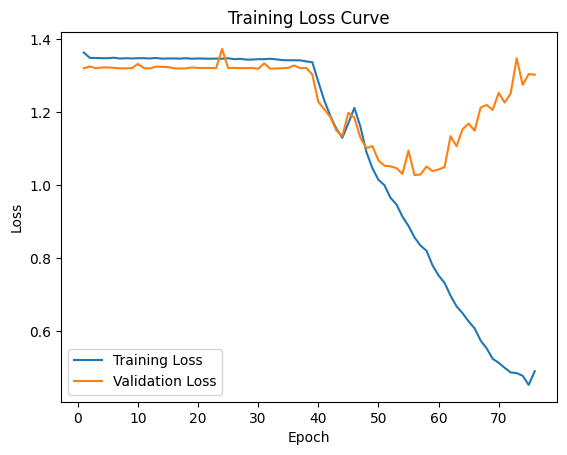

In [22]:
model = LSTMClassifier(vocab_size=len(vocab), embed_dim=128, hidden_dim=128, output_dim=5)
model.to(device)

# Train the LSTM model
train_model(model, train_loader_lstm, val_loader_lstm, num_epochs=100, plot=True)

Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Accuracy: 0.5721
Precision: 0.5537, Recall: 0.5721, F1 Score: 0.5595
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60       209
           1       0.36      0.31      0.34       226
           2       0.35      0.30      0.33       287
           3       0.47      0.40      0.43       812
           4       0.68      0.80      0.74      1207

    accuracy                           0.57      2741
   macro avg       0.50      0.48      0.49      2741
weighted avg       0.55      0.57      0.56      2741



Evaluating:   0%|          | 0/86 [00:00<?, ?it/s]

Accuracy: 0.8336
Precision: 0.8236, Recall: 0.8336, F1 Score: 0.8277
Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.70      0.74       435
     Neutral       0.35      0.30      0.33       287
    Positive       0.90      0.94      0.92      2019

    accuracy                           0.83      2741
   macro avg       0.68      0.65      0.66      2741
weighted avg       0.82      0.83      0.83      2741



(0.8336373586282378,
 0.8236211906772468,
 0.8336373586282378,
 0.8277032656378208)

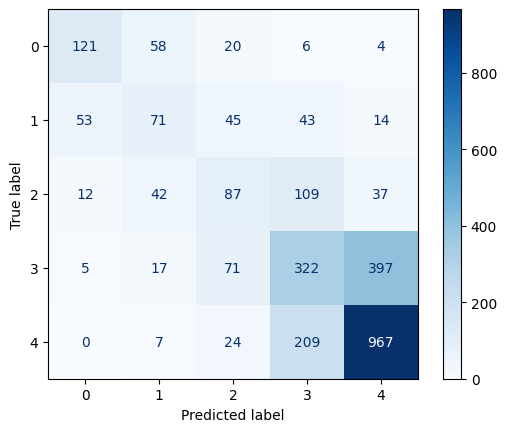

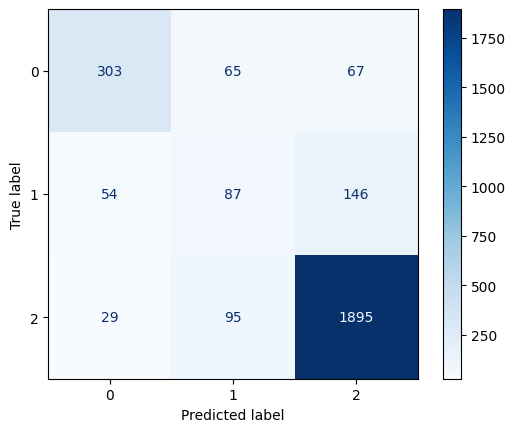

In [ ]:
evaluate_model(model, test_loader_lstm)
evaluate_model_as_sentiment(model, test_loader_lstm)